## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


## Set Paths and Load Filenames

In [3]:
import os
import pandas as pd

# Update this path to where your Act1, Act2... folders are saved
BASE_DIR = BASE_DIR = r"D:\mars\emotion_detection\data"  # if your data folders are inside 'emotion-classifier/data'

data = []

for act in os.listdir(BASE_DIR):
    act_path = os.path.join(BASE_DIR, act)
    if os.path.isdir(act_path):
        for file in os.listdir(act_path):
            if file.endswith(".wav") or file.endswith(".mp3"):
                label = file.split('_')[0].lower()  # e.g., happy_01.wav => happy
                file_path = os.path.join(act_path, file)
                data.append((file_path, label))

# Create DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])

# Preview data
print(df['label'].value_counts())
df.head()


label
03-01-08-02-02-02-24.wav    1
03-01-05-01-01-01-01.wav    1
03-01-05-01-01-01-02.wav    1
03-01-05-01-01-01-03.wav    1
03-01-08-02-02-02-08.wav    1
                           ..
03-01-05-01-01-01-09.wav    1
03-01-05-01-01-01-08.wav    1
03-01-05-01-01-01-07.wav    1
03-01-05-01-01-01-06.wav    1
03-01-05-01-01-01-05.wav    1
Name: count, Length: 2452, dtype: int64


,file_path,label
0,D:\mars\emotion_detection\data\angry\03-01-05-...,03-01-05-01-01-01-01.wav
1,D:\mars\emotion_detection\data\angry\03-01-05-...,03-01-05-01-01-01-02.wav
2,D:\mars\emotion_detection\data\angry\03-01-05-...,03-01-05-01-01-01-03.wav
3,D:\mars\emotion_detection\data\angry\03-01-05-...,03-01-05-01-01-01-04.wav
4,D:\mars\emotion_detection\data\angry\03-01-05-...,03-01-05-01-01-01-05.wav


In [17]:
import os

BASE_DIR = r"D:\mars\emotion_detection\data"

print("Folders inside /data:")
print(os.listdir(BASE_DIR))


Folders inside /data:
['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [21]:
import os
import pandas as pd

# ✅ Path to your emotion folders
BASE_DIR = r"D:\mars\emotion_detection\data"

data = []

# Each folder is an emotion label: angry, sad, happy, etc.
for emotion in os.listdir(BASE_DIR):
    emotion_path = os.path.join(BASE_DIR, emotion)
    if os.path.isdir(emotion_path):
        for file in os.listdir(emotion_path):
            if file.endswith(".wav") or file.endswith(".mp3"):
                file_path = os.path.join(emotion_path, file)
                data.append((file_path, emotion.lower()))

# Create DataFrame
df = pd.DataFrame(data, columns=['file_path', 'label'])

# Summary
print(df['label'].value_counts())
df.head()


label
angry        376
calm         376
fearful      376
happy        376
sad          376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64


,file_path,label
0,D:\mars\emotion_detection\data\angry\03-01-05-...,angry
1,D:\mars\emotion_detection\data\angry\03-01-05-...,angry
2,D:\mars\emotion_detection\data\angry\03-01-05-...,angry
3,D:\mars\emotion_detection\data\angry\03-01-05-...,angry
4,D:\mars\emotion_detection\data\angry\03-01-05-...,angry


In [24]:
import librosa
import numpy as np
from tqdm import tqdm  # for progress bar

import librosa

def extract_mfcc(file_path, sr=22050, duration=3, n_mfcc=40):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(audio) < sr * duration:
            return None
        mfccs = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=n_mfcc)
        return mfccs
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        return None



In [6]:
## Feature Extraction and Label Encoding

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


for path in df['file_path'].head(5):
    print(f"{path} -> exists: {os.path.exists(path)}")

print("\nNumber of audio files found:", len(df))
print("\nUnique emotion labels detected:", df['label'].unique())

# Initialize lists
X, y = [], []

print("First few entries in DataFrame:")
print(df.head())

# Extract MFCC features
for path, label in tqdm(df.values, desc="Extracting MFCCs"):
    mfcc = extract_mfcc(path)
    if mfcc is not None:
        X.append(mfcc)
        y.append(label)

print(f"Extracted {len(X)} MFCC feature sets.")
print(f"Labels collected: {set(y)}")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X for CNN input (add channel dimension)
X = X[..., np.newaxis]  # Shape becomes (samples, 40, 130, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Output summary
print("✅ Feature extraction complete!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("y categorical shape:", y_cat.shape)


D:\mars\emotion_detection\data\angry\03-01-05-01-01-01-01.wav -> exists: True
D:\mars\emotion_detection\data\angry\03-01-05-01-01-01-02.wav -> exists: True
D:\mars\emotion_detection\data\angry\03-01-05-01-01-01-03.wav -> exists: True
D:\mars\emotion_detection\data\angry\03-01-05-01-01-01-04.wav -> exists: True
D:\mars\emotion_detection\data\angry\03-01-05-01-01-01-05.wav -> exists: True

Number of audio files found: 2452

Unique emotion labels detected: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
First few entries in DataFrame:
                                           file_path  label
0  D:\mars\emotion_detection\data\angry\03-01-05-...  angry
1  D:\mars\emotion_detection\data\angry\03-01-05-...  angry
2  D:\mars\emotion_detection\data\angry\03-01-05-...  angry
3  D:\mars\emotion_detection\data\angry\03-01-05-...  angry
4  D:\mars\emotion_detection\data\angry\03-01-05-...  angry


Extracting MFCCs: 100%|██████████| 2452/2452 [00:50<00:00, 48.53it/s]


Extracted 2450 MFCC feature sets.
Labels collected: {'sad', 'happy', 'surprised', 'calm', 'fearful', 'neutral', 'angry', 'disgust'}
✅ Feature extraction complete!
X shape: (2450, 40, 130, 1)
y shape: (2450,)
y categorical shape: (2450, 8)


In [8]:
## Label Encoding and One-Hot Encoding (Separate)

In [29]:
# Label Encoding and One-Hot Encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the label encoder
label_encoder = LabelEncoder()

# Convert string labels to integers
y_encoded = label_encoder.fit_transform(y)

# Convert integer labels to one-hot encoded format
y_categorical = to_categorical(y_encoded)

# Optional: Print label classes and shape for verification
print("Classes:", label_encoder.classes_)
print("y_encoded shape:", y_encoded.shape)
print("y_categorical shape:", y_categorical.shape)


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
y_encoded shape: (2450,)
y_categorical shape: (2450, 8)


In [10]:
##  CNN Model Architecture for Speech Emotion Classification

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import Input

# Define the CNN model
model = Sequential([
    Input(shape=(40, 130, 1)),  # Input shape for MFCCs
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(8, activation='softmax')  # 8 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 38, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,031,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,051,592 (7.83 MB)

 Trainable params: 2,051,592 (7.83 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
## Train-Test Split and Model Training

In [39]:
from sklearn.model_selection import train_test_split

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',     # Watch validation loss
    patience=5,             # Stop if no improvement after 5 epochs
    restore_best_weights=True  # Load best weights after stop
)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)



Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9330 - loss: 0.1730 - val_accuracy: 0.6122 - val_loss: 1.3193
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9514 - loss: 0.1419 - val_accuracy: 0.6378 - val_loss: 1.4358
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9424 - loss: 0.1596 - val_accuracy: 0.6199 - val_loss: 1.4251
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9508 - loss: 0.1526 - val_accuracy: 0.6352 - val_loss: 1.4232
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9493 - loss: 0.1451 - val_accuracy: 0.6582 - val_loss: 1.3833
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9549 - loss: 0.1459 - val_accuracy: 0.6429 - val_loss: 1.2356
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9605 - loss: 0.1265 - val_accuracy: 0.6633 - val_loss: 1.2118
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9412 - loss: 0.1527 - val_accuracy: 0.6173 - v

## Training Accuracy & Loss Visualization

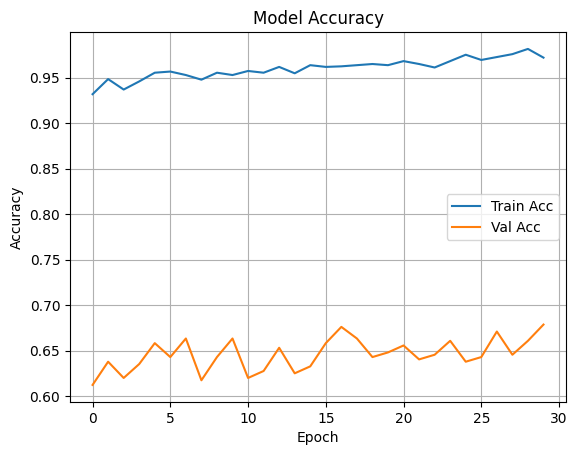

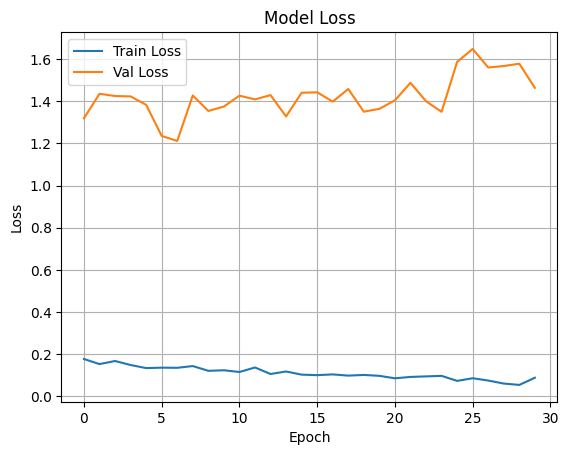

In [40]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


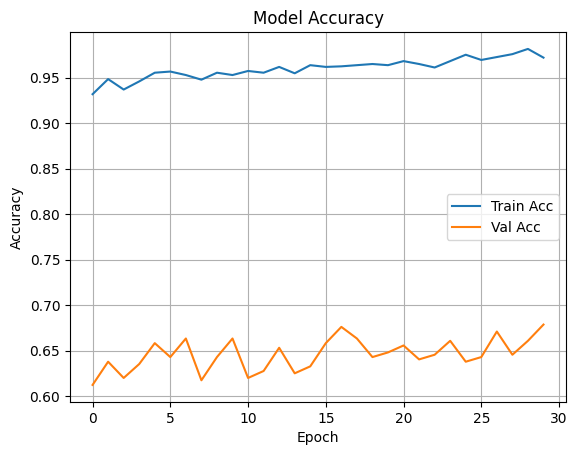

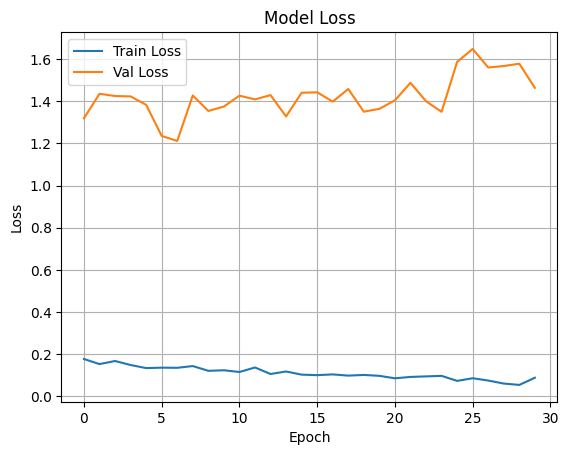

In [41]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Evaluate Model Performance on Test Data

In [42]:
# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6060 - loss: 1.7860

🎯 Test Accuracy: 58.98%
📉 Test Loss: 1.8253


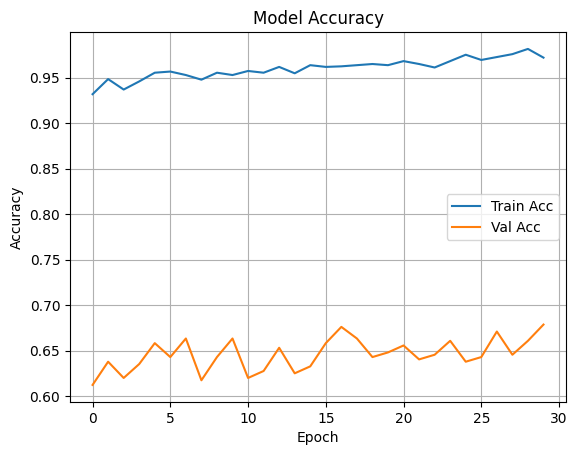

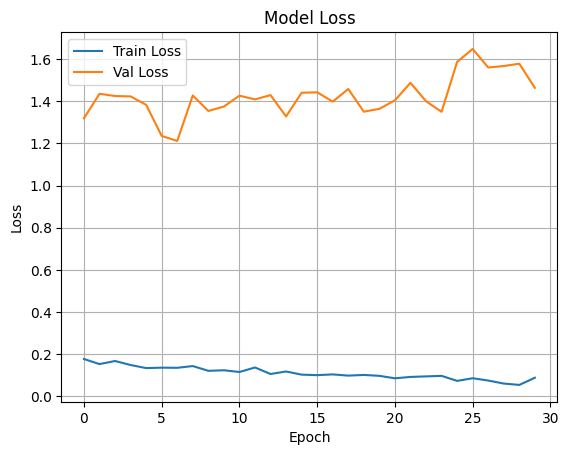

In [44]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Plot Confusion Matrix to Evaluate Class-wise Predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


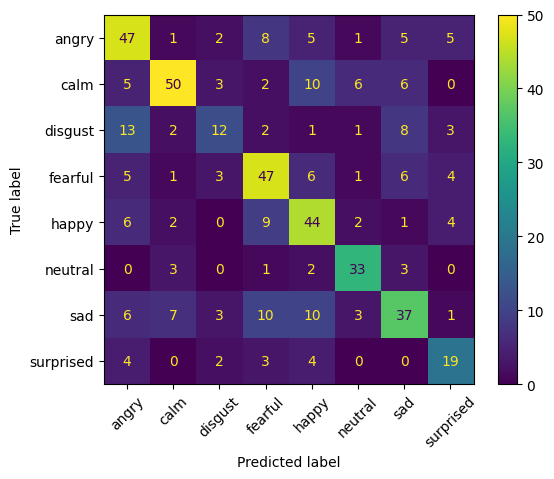

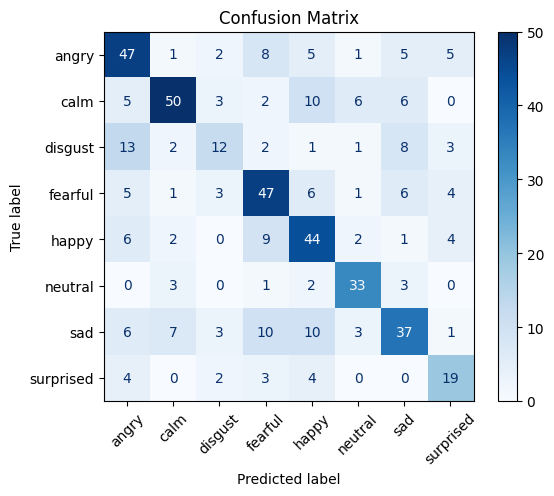

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix")
plt.show()


# Improved CNN 

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     LeakyReLU, Dropout, GlobalAveragePooling2D, Dense)

model = Sequential([
    Input(shape=(40, 130, 1)),

    # Conv Block 1
    Conv2D(32, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 2
    Conv2D(64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 3
    Conv2D(128, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Optional 4th Conv Block (for larger datasets)
    Conv2D(256, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Global Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Fully Connected
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(8, activation='softmax')  # 8 emotion classes
])


In [49]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 40, 130, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 130, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 40, 130, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 20, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 10, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 16, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 16, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 5, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 423,688 (1.62 MB)

 Trainable params: 422,728 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7893 - loss: 0.5572 - val_accuracy: 0.6148 - val_loss: 1.1269
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.7716 - loss: 0.6376 - val_accuracy: 0.6071 - val_loss: 1.1697
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.7461 - loss: 0.6669 - val_accuracy: 0.6301 - val_loss: 1.0917
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.7993 - loss: 0.5665 - val_accuracy: 0.6071 - val_loss: 1.1362
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.7759 - loss: 0.5945 - val_accuracy: 0.6097 - val_loss: 1.1573
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.7781 - loss: 0.6054 - val_accuracy: 0.6097 - val_loss: 1.1376
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 272ms/step - accuracy: 0.7922 - loss: 0.5889 - val_accuracy: 0.6097 - val_loss: 1.1713
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.7837 - loss: 0.6003 - val_accur

In [62]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5676 - loss: 1.2134

🎯 Test Accuracy: 56.94%
📉 Test Loss: 1.2421


In [63]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.7878 - loss: 0.5840 - val_accuracy: 0.6224 - val_loss: 1.1031 - learning_rate: 1.5625e-05
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - accuracy: 0.7790 - loss: 0.5822 - val_accuracy: 0.6276 - val_loss: 1.1233 - learning_rate: 1.5625e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.7731 - loss: 0.5953 - val_accuracy: 0.6301 - val_loss: 1.1093 - learning_rate: 1.5625e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - accuracy: 0.7919 - loss: 0.5823 - val_accuracy: 0.6301 - val_loss: 1.1247 - learning_rate: 1.5625e-05
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.7719 - loss: 0.5942 - val_accuracy: 0.6250 - val_loss: 1.1009 - learning_rate: 7.8125e-06
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.7795 - loss: 0.5881 - val_accuracy: 0.6224 - val_loss: 1.1206 - learning_rate: 7.8125e-06
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - acc

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5654 - loss: 1.2305

🎯 Test Accuracy: 56.33%
📉 Test Loss: 1.2612


In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - accuracy: 0.7850 - loss: 0.5794 - val_accuracy: 0.6224 - val_loss: 1.1090 - learning_rate: 3.9063e-06
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.7649 - loss: 0.6337 - val_accuracy: 0.6199 - val_loss: 1.1299 - learning_rate: 3.9063e-06
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.7970 - loss: 0.5888 - val_accuracy: 0.6199 - val_loss: 1.1442 - learning_rate: 3.9063e-06
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step - accuracy: 0.7753 - loss: 0.5656 - val_accuracy: 0.6173 - val_loss: 1.1394 - learning_rate: 3.9063e-06
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - accuracy: 0.7902 - loss: 0.5931 - val_accuracy: 0.6173 - val_loss: 1.1367 - learning_rate: 1.9531e-06
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 290ms/step - accuracy: 0.7835 - loss: 0.5783 - val_accuracy: 0.6199 - val_loss: 1.1390 - learning_rate: 1.9531e-06
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - acc

In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5757 - loss: 1.1676

🎯 Test Accuracy: 56.12%
📉 Test Loss: 1.1795


In [69]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("y_cat shape:", y_cat.shape)
print("Unique labels:", np.unique(y))
print("Categorical sample (first):", y_cat[0])


X shape: (2450, 40, 130, 1)
y shape: (2450,)
y_cat shape: (2450, 8)
Unique labels: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Categorical sample (first): [1. 0. 0. 0. 0. 0. 0. 0.]


In [71]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     LeakyReLU, Dropout, Reshape, Bidirectional,
                                     LSTM, Dense, GlobalAveragePooling2D,TimeDistributed)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

inp = Input(shape=(40, 130, 1))

x = Conv2D(32, (3, 3), padding='same')(inp)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Shape before RNN: (10, 43, 64)
x = Reshape((10, 2048))(x)
x = TimeDistributed(Dense(256))(x)  # Compress features  # reshape for LSTM input

x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

out = Dense(8, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 40, 130, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 40, 130, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 40, 130, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 40, 130, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 20, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 20, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 20, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 10, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 256)        │       524,544 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,872 (2.73 MB)

 Trainable params: 716,680 (2.73 MB)

 Non-trainable params: 192 (768.00 B)

In [78]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Dropout,
                                     Reshape, Bidirectional, LSTM, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Normalize input
X = X.astype('float32')
X = (X - np.mean(X)) / np.std(X)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# Define model
input_layer = Input(shape=(40, 130, 1))

x = Conv2D(32, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Reshape for RNN
x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)

x = Bidirectional(LSTM(64))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Unique classes in `y`:", np.unique(y))
print("Shape of y_cat:", y_cat.shape)


# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.1409 - loss: 2.1230 - val_accuracy: 0.1480 - val_loss: 2.0656 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.1658 - loss: 2.0465 - val_accuracy: 0.1658 - val_loss: 2.0497 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.1845 - loss: 2.0164 - val_accuracy: 0.1658 - val_loss: 2.0382 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.1973 - loss: 2.0024 - val_accuracy: 0.1556 - val_loss: 2.0349 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.2098 - loss: 1.9681 - val_accuracy: 0.1556 - val_loss: 2.0225 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.2380 - loss: 1.9234 - val_accuracy: 0.1888 - val_loss: 2.0202 - learning_rate: 1.0000e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accu

In [80]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, 
                                     Reshape, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import os

# ✅ Set seeds to stabilize results
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# ✅ Normalize input
X = (X - np.mean(X)) / np.std(X)

# ✅ Encode string labels to integers
le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = to_categorical(y_int, num_classes=8)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=seed, stratify=y_cat)

# ✅ Model definition
input_layer = Input(shape=(40, 130, 1), name='input_layer')

x = Conv2D(32, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # (20, 65)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # (10, 32)

x = Reshape((10, 32 * 64))(x)  # Reshape to (10, 2048)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

# ✅ Compile
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# ✅ Train
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

# ✅ Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.1582 - loss: 2.3823 - val_accuracy: 0.2092 - val_loss: 2.0689 - learning_rate: 3.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.2909 - loss: 1.9632 - val_accuracy: 0.1633 - val_loss: 2.0546 - learning_rate: 3.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.3806 - loss: 1.7523 - val_accuracy: 0.1480 - val_loss: 2.0565 - learning_rate: 3.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.4771 - loss: 1.5708 - val_accuracy: 0.2347 - val_loss: 2.0262 - learning_rate: 3.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.5536 - loss: 1.4604 - val_accuracy: 0.2806 - val_loss: 1.9770 - learning_rate: 3.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.6328 - loss: 1.3035 - val_accuracy: 0.3112 - val_loss: 1.9138 - learning_rate: 3.0000e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, 
                                     Reshape, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D,Layer)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import os

class Attention(Layer):
    def call(self, inputs):
        score = K.tanh(inputs)
        weights = K.softmax(score, axis=1)
        context = K.sum(inputs * weights, axis=1)
        return context 
    
# ✅ Set seeds to stabilize results
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# ✅ Normalize input
X = (X - np.mean(X)) / np.std(X)

# ✅ Encode string labels to integers
le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = to_categorical(y_int, num_classes=8)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=seed, stratify=y_cat)

# ✅ Model definition
input_layer = Input(shape=(40, 130, 1), name='input_layer')

x = Conv2D(32, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # (20, 65)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # (10, 32)

x = Reshape((10, 32 * 64))(x)  # Reshape to (10, 2048)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)

x = Attention()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

# ✅ Compile
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# ✅ Train
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

# ✅ Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")



Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.2045 - loss: 2.1352 - val_accuracy: 0.1531 - val_loss: 2.0807 - learning_rate: 2.0000e-04
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.3695 - loss: 1.7723 - val_accuracy: 0.2092 - val_loss: 2.0592 - learning_rate: 2.0000e-04
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.4507 - loss: 1.6423 - val_accuracy: 0.1454 - val_loss: 2.0920 - learning_rate: 2.0000e-04
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.5217 - loss: 1.4994 - val_accuracy: 0.1811 - val_loss: 2.1133 - learning_rate: 2.0000e-04
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.6031 - loss: 1.3666 - val_accuracy: 0.2219 - val_loss: 2.1502 - learning_rate: 2.0000e-04
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.7147 - loss: 1.1624 - val_accuracy: 0.2577 - val_loss: 2.5629 - learning_rate: 1.0000e-04
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accur

In [29]:
## Save the Trained Model

In [83]:
# 📦 Cell 11: Save Trained Models in Different Formats

# Save as HDF5 (standard Keras format)
model.save("best_model.h5")

# Save a smaller version for lightweight testing
model.save("emotion_model_v1.h5")

# Save in the modern .keras format
model.save("emotion_model.keras")

print("✅ Models saved: best_model.h5, emotion_model_v1.h5, emotion_model.keras")


✅ Models saved: best_model.h5, emotion_model_v1.h5, emotion_model.keras


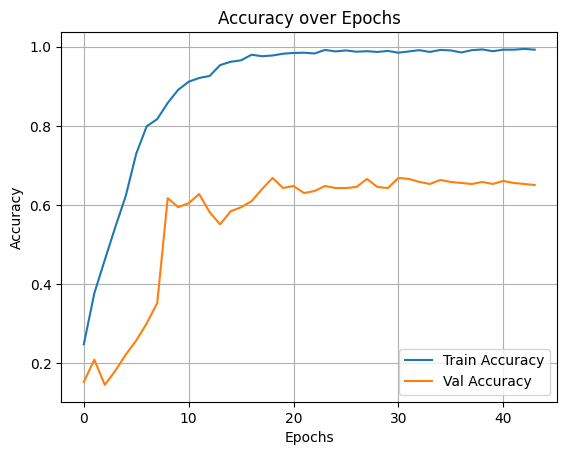

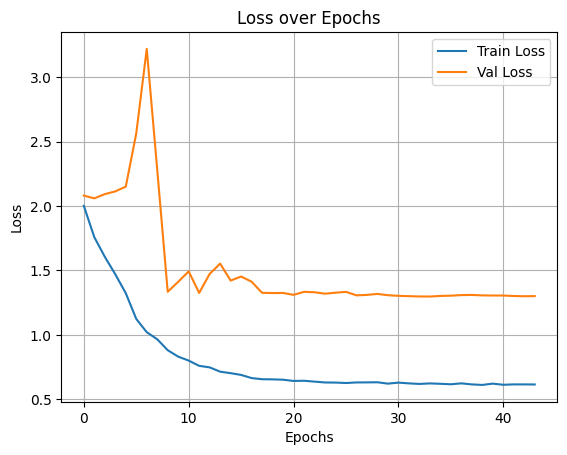

In [85]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


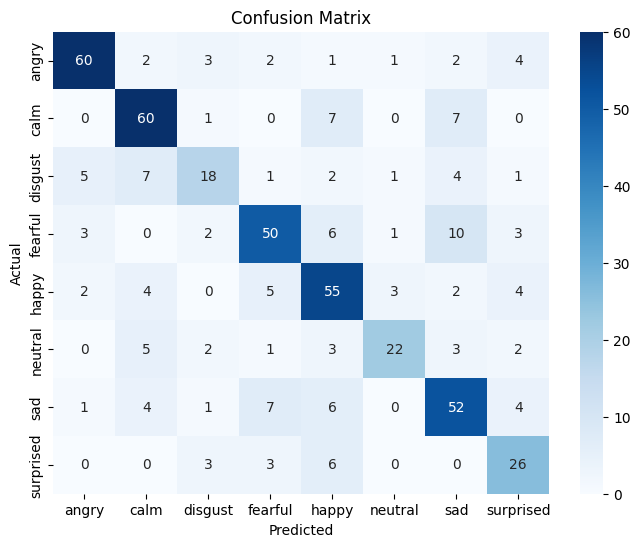

              precision    recall  f1-score   support

       angry       0.85      0.80      0.82        75
        calm       0.73      0.80      0.76        75
     disgust       0.60      0.46      0.52        39
     fearful       0.72      0.67      0.69        75
       happy       0.64      0.73      0.68        75
     neutral       0.79      0.58      0.67        38
         sad       0.65      0.69      0.67        75
   surprised       0.59      0.68      0.63        38

    accuracy                           0.70       490
   macro avg       0.70      0.68      0.68       490
weighted avg       0.70      0.70      0.70       490



In [87]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict classes
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))


### Detailed Evaluation (Confusion Matrix + Classification Report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


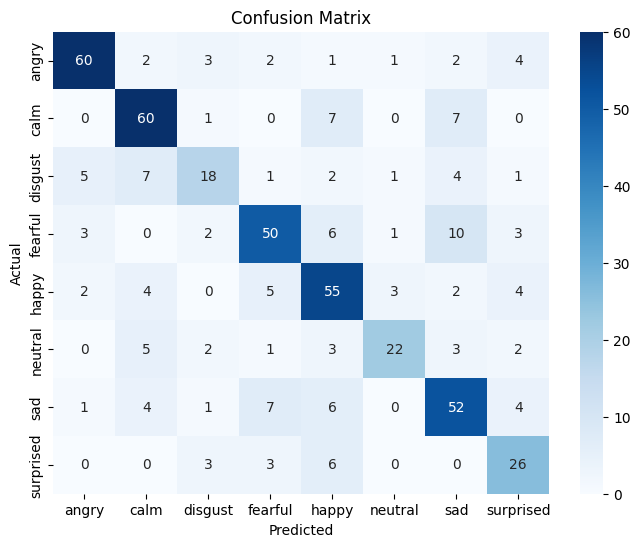


📋 Classification Report:

              precision    recall  f1-score   support

       angry       0.85      0.80      0.82        75
        calm       0.73      0.80      0.76        75
     disgust       0.60      0.46      0.52        39
     fearful       0.72      0.67      0.69        75
       happy       0.64      0.73      0.68        75
     neutral       0.79      0.58      0.67        38
         sad       0.65      0.69      0.67        75
   surprised       0.59      0.68      0.63        38

    accuracy                           0.70       490
   macro avg       0.70      0.68      0.68       490
weighted avg       0.70      0.70      0.70       490



In [88]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification report
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


### Plot Accuracy & Loss Over Epochs

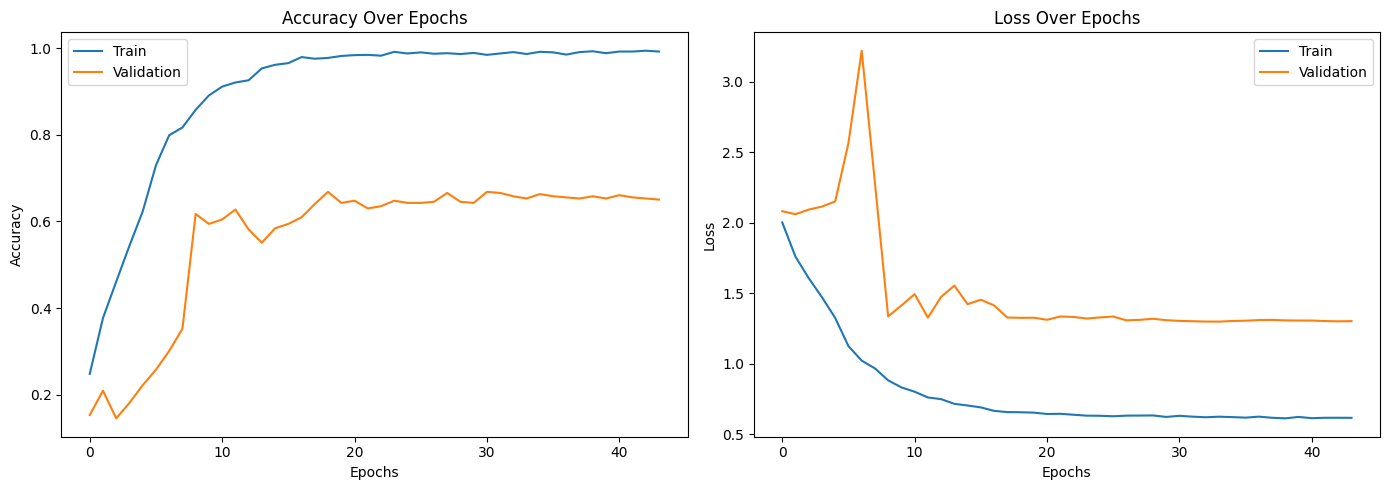

In [89]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Test Sample Predictions

In [90]:
import random

# Pick random samples from test set
num_samples = 10
sample_indices = random.sample(range(X_test.shape[0]), num_samples)

#  Predict on selected samples
sample_X = X_test[sample_indices]
sample_y_true = np.argmax(y_test[sample_indices], axis=1)
sample_y_pred = np.argmax(model.predict(sample_X), axis=1)

print(" Emotion Prediction Results:\n")
for i, idx in enumerate(sample_indices):
    true_label = le.classes_[sample_y_true[i]]
    pred_label = le.classes_[sample_y_pred[i]]
    print(f"Sample {i+1}:  Actual: {true_label}  |   Predicted: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
 Emotion Prediction Results:

Sample 1:  Actual: happy  |   Predicted: happy
Sample 2:  Actual: calm  |   Predicted: calm
Sample 3:  Actual: angry  |   Predicted: disgust
Sample 4:  Actual: calm  |   Predicted: calm
Sample 5:  Actual: angry  |   Predicted: angry
Sample 6:  Actual: sad  |   Predicted: sad
Sample 7:  Actual: calm  |   Predicted: calm
Sample 8:  Actual: fearful  |   Predicted: disgust
Sample 9:  Actual: fearful  |   Predicted: fearful
Sample 10:  Actual: happy  |   Predicted: sad


### Run the Prediction Comparison Cell

In [91]:
import random

#  Pick random samples from test set
num_samples = 10
sample_indices = random.sample(range(X_test.shape[0]), num_samples)

#  Predict on selected samples
sample_X = X_test[sample_indices]
sample_y_true = np.argmax(y_test[sample_indices], axis=1)
sample_y_pred = np.argmax(model.predict(sample_X), axis=1)

print(" Emotion Prediction Results:\n")
for i, idx in enumerate(sample_indices):
    true_label = le.classes_[sample_y_true[i]]
    pred_label = le.classes_[sample_y_pred[i]]
    print(f"Sample {i+1}:  Actual: {true_label}  |  🤖 Predicted: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
 Emotion Prediction Results:

Sample 1:  Actual: neutral  |  🤖 Predicted: neutral
Sample 2:  Actual: happy  |  🤖 Predicted: happy
Sample 3:  Actual: sad  |  🤖 Predicted: sad
Sample 4:  Actual: disgust  |  🤖 Predicted: disgust
Sample 5:  Actual: surprised  |  🤖 Predicted: surprised
Sample 6:  Actual: calm  |  🤖 Predicted: sad
Sample 7:  Actual: neutral  |  🤖 Predicted: neutral
Sample 8:  Actual: neutral  |  🤖 Predicted: happy
Sample 9:  Actual: fearful  |  🤖 Predicted: fearful
Sample 10:  Actual: surprised  |  🤖 Predicted: surprised


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


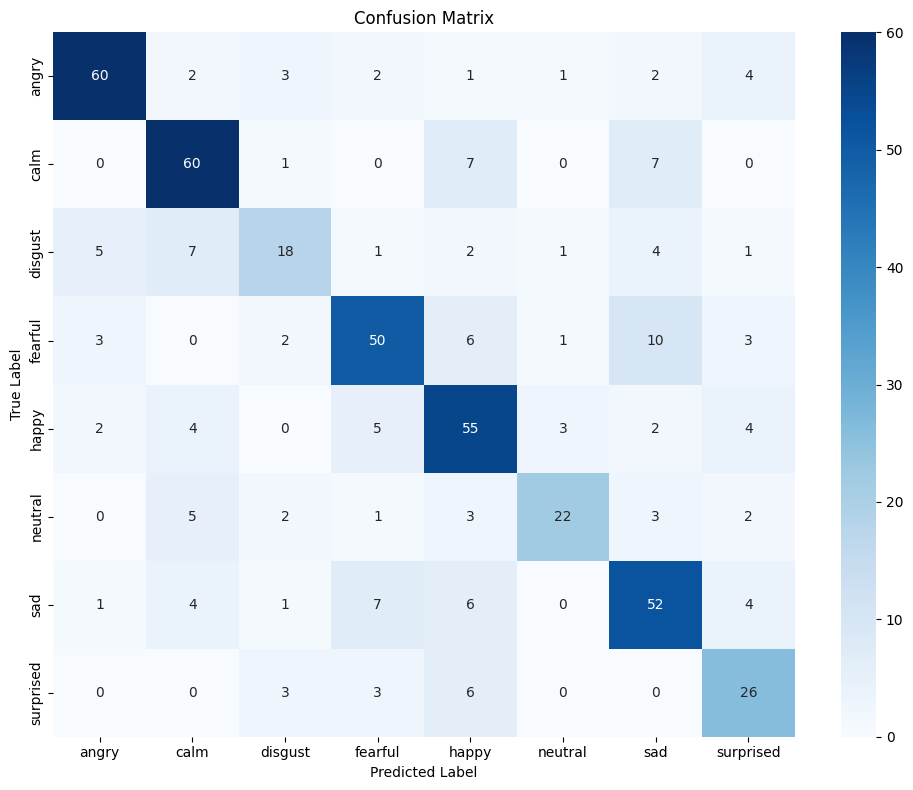

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
emotion_labels = le.classes_

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix")  # Removed emoji to avoid warning
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [93]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))

macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print("Macro F1 Score:", macro_f1)
print("Weighted F1 Score:", weighted_f1)


Accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

       angry       0.85      0.80      0.82        75
        calm       0.73      0.80      0.76        75
     disgust       0.60      0.46      0.52        39
     fearful       0.72      0.67      0.69        75
       happy       0.64      0.73      0.68        75
     neutral       0.79      0.58      0.67        38
         sad       0.65      0.69      0.67        75
   surprised       0.59      0.68      0.63        38

    accuracy                           0.70       490
   macro avg       0.70      0.68      0.68       490
weighted avg       0.70      0.70      0.70       490

Macro F1 Score: 0.6821803946274562
Weighted F1 Score: 0.6987664220000174


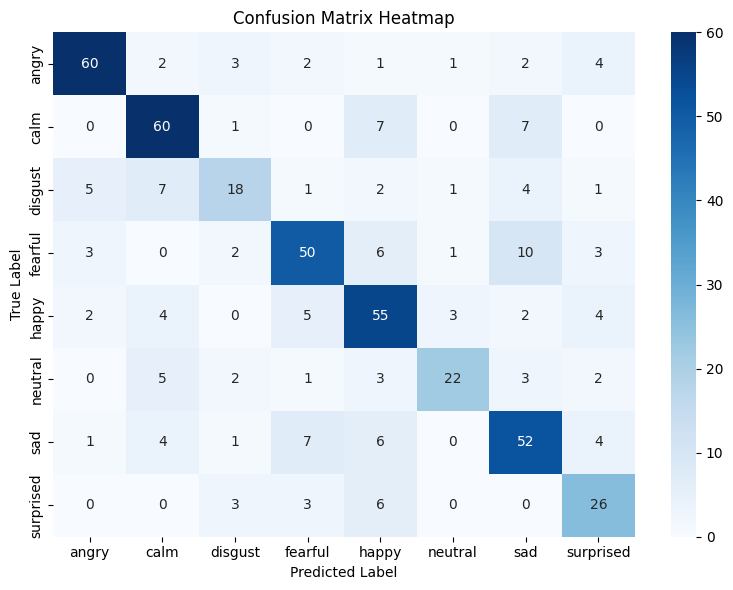


✅ Confusion Matrix (Raw Values):

           angry        calm     disgust     fearful       happy     neutral         sad   surprised
     angry          60           2           3           2           1           1           2           4
      calm           0          60           1           0           7           0           7           0
   disgust           5           7          18           1           2           1           4           1
   fearful           3           0           2          50           6           1          10           3
     happy           2           4           0           5          55           3           2           4
   neutral           0           5           2           1           3          22           3           2
       sad           1           4           1           7           6           0          52           4
 surprised           0           0           3           3           6           0           0          26


In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define emotion labels from LabelEncoder
emotion_labels = label_encoder.classes_

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Print matrix as plain text
print("\n✅ Confusion Matrix (Raw Values):\n")
print("      " + "  ".join(f"{label:>10}" for label in emotion_labels))
for i, row in enumerate(cm):
    print(f"{emotion_labels[i]:>10}  " + "  ".join(f"{val:>10}" for val in row))


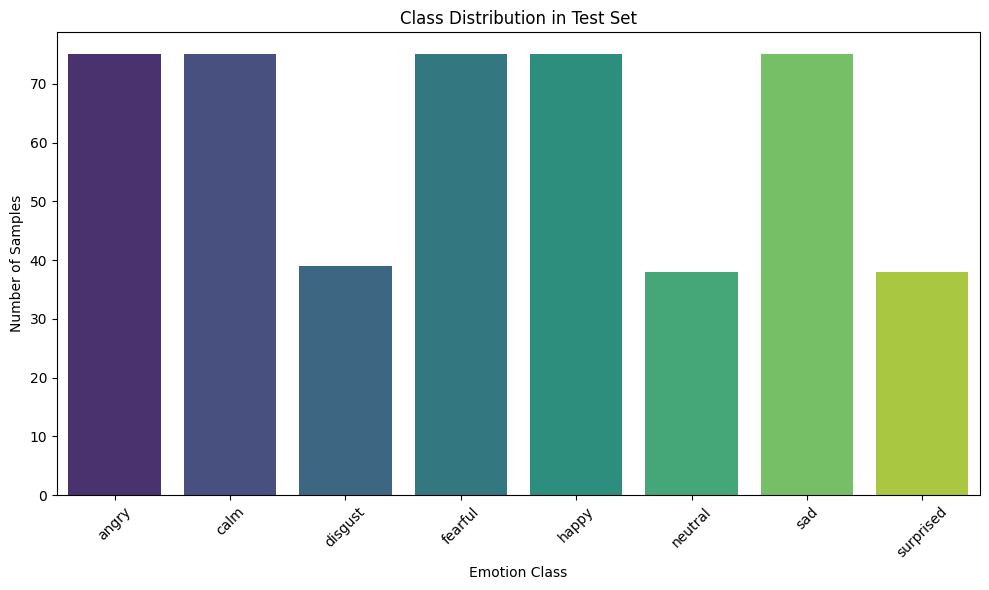

{np.str_('angry'): np.int64(75),
 np.str_('calm'): np.int64(75),
 np.str_('disgust'): np.int64(39),
 np.str_('fearful'): np.int64(75),
 np.str_('happy'): np.int64(75),
 np.str_('neutral'): np.int64(38),
 np.str_('sad'): np.int64(75),
 np.str_('surprised'): np.int64(38)}

In [109]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert y_test from one-hot to label indices if needed
y_true = np.argmax(y_test, axis=1)

# Emotion labels (already from LabelEncoder)
emotion_labels = le.classes_

# Count each class
unique, counts = np.unique(y_true, return_counts=True)
class_distribution = dict(zip([emotion_labels[i] for i in unique], counts))

# Plot class distribution (Future-proofed)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), hue=list(class_distribution.keys()), legend=False, palette='viridis')
plt.title("Class Distribution in Test Set")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_distribution